# **Project: Multitask Learning for Geometric Shape Classification and Counting**

## 1. Overview

In this project, you will design, implement, and evaluate a **multitask neural network** that performs **two tasks simultaneously**:

1. **Classification** – identify which pair of geometric shape types appears in a 28×28 binary image (135 possible configurations).
2. **Regression** – predict how many shapes of each type are present (6 regression targets).

This project focuses on **multi-task learning**, i.e., using one shared model to learn several related tasks at once. You will compare how adding an auxiliary task affects performance and training dynamics.

---

## 2. Dataset

You will use the **Geometric Shape Numbers (GSN)** dataset:

```bash
!wget https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
!unzip data_gsn.zip &> /dev/null
!rm data_gsn.zip
```

This will create a directory `data/` containing:

* **10,000 images** (28×28x1, grayscale)
* **labels.csv** – counts of each of six shape types per image

Each image contains exactly **two types** of geometric figures (out of six) and **10 shapes total**.

**Shape classes:**

| Index | Shape type     |
| ----: | -------------- |
|     0 | square         |
|     1 | circle         |
|     2 | triangle up    |
|     3 | triangle right |
|     4 | triangle down  |
|     5 | triangle left  |

Example row from `labels.csv`:

```
name,squares,circles,up,right,down,left
img_00000.png,0,0,0,4,0,6
```

Here, the image contains **4 right-pointing triangles** and **6 left-pointing triangles**.

**Split:**

* Training: first 9,000 samples
* Validation: last 1,000 samples

Examples:
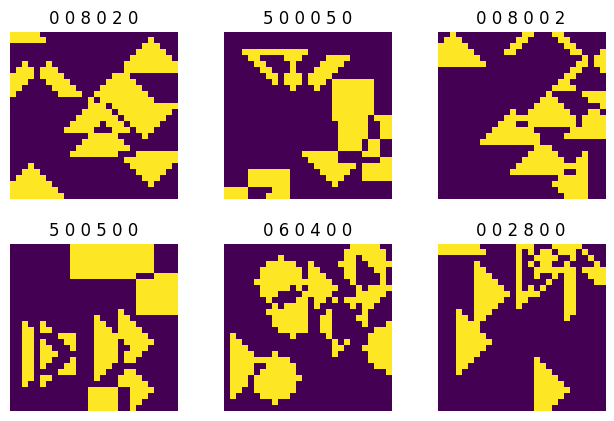

---

## 3. Tasks and objectives

You must design a **multitask deep learning system** that:

1. **Classifies** each image into one of **135 possible configurations**, representing:

   * which **two shape classes** appear, and
   * how their counts (1–9) sum to 10.

   → Example: "3 circles + 7 squares" is one configuration class.

2. **Regresses** the number of shapes of each type (a 6-dimensional real-valued output).

3. Combines both objectives in a **joint loss** function (Hint: losses are implemented in PyTorch):


$$ Loss = \text{NLLLoss(classification)} + \lambda_{\text{cnt}} \cdot \text{SmoothL1Loss(regression)}
$$

---

## 4. Model requirements

### Architecture constraints

You must use **exactly this feature extractor (backbone)**:

```python
nn.Sequential(
    nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(),
    nn.Flatten(start_dim=1),
    nn.Linear(64 * 28 * 28, 256), nn.ReLU()
)
```

Then add **two separate heads**:

* `head_cls`: outputs log-probabilities for 135 classes
* `head_cnt`: outputs 6 regression values (counts)

The model must return two outputs: `(log_probs, counts)`.

You may add dropout or batch normalization inside the heads, **but you must not modify the backbone**.

---

## 5. Training setup

* Optimizer: **Adam**, learning rate = 1e-3
* Epochs: up to **100** (use **early stopping**)
* Batch sizes: **64** (train), **1000** (validation)
* Device: GPU allowed for Notebook, but your **final code must run on GPU within ~30 minutes**
* Random seed: set `torch.manual_seed(1)` for reproducibility
* Split: **exactly 9,000 train / 1,000 validation**


---

## 6. Data preprocessing and augmentation

You must implement a **PyTorch `Dataset` class** that:

* Reads `labels.csv`
* Loads the corresponding image (from `data/`)
* Returns both:
  * the image (as a tensor)
  * the labels (counts for 6 shapes)
* Optionally applies transformations

### Required augmentations

You must implement **at least three** of the following:

1. Random horizontal flip
2. Random vertical flip
3. Random 90° rotation (must correctly rotate orientation labels: up → right → down → left)
4. Random brightness/contrast (mild)
5. Gaussian noise
6. Random erasing (small areas only)


---

## 7. Evaluation metrics

Implement and report the following metrics on the validation set:

### (a) **Classification (135-way)**

* Top-1 accuracy
* Macro F1-score
* Per-pair accuracy (aggregate by unordered shape pair, e.g. {circle, up})

### (b) **Regression (6-D counts)**

* RMSE per class and overall
* MAE per class and overall

Also plot:

* Training and validation losses
* Validation accuracy and RMSE over epochs

**Important**: This task is not about finding the best architecture; we expect at least 50% accuracy, but achieving results higher than that will not affect the grade for the assignment**.


---

## 8. Experiments and analysis

You must train and compare **three model settings**:

| Setting | Description                                      |
| :------ | :----------------------------------------------- |
| 1       | **Classification-only:** λ_cnt = 0               |
| 2       | **Regression-only:** classification loss ignored |
| 3       | **Multitask:** λ_cnt = with your choose          |

For each experiment:

* Train until early stopping
* Record loss, accuracy, RMSE, and runtime
* Compare results and explain how λ influences learning
* Discuss whether multitask learning improves the main tasks


---

## 9. Final deliverables

You must submit .zip project with:

1. **Code** (`.ipynb` or `.py`) that:

   * Downloads and extracts the dataset
   * Defines dataset, dataloaders, model, loss, training loop, evaluation, and plotting
   * Can run start-to-end without interaction, and finishes within 30 minutes on Colab T4 GPUs
   * Includes three experiment configurations

2. **Report (2–4 pages, PDF)** including:
   * Section on (EDA) Exploratory Data Analysis in your report: no more than 3 graphs or tables describing the data set.
   * Model architecture
   * Description and justification of augmentations
   * Results table (loss, accuracy, RMSE for all runs)
   * Learning curves
   * Discussion on multitask effects

3. **README.md**:

   * Link to Colab version of task for fast replication.
   * Approximate runtime and resource requirements

---

## 10. Grading rubric

Component	Description	Points
1. Implementation correctness	Correct use of the fixed backbone, two-headed model, and proper training loop (classification + regression).	30%
2. Data & augmentations	Proper dataset loading, preprocessing, and at least three augmentations with brief justification.	20%
3. Evaluation & experiments	Correct computation of metrics (accuracy, F1, RMSE) and completion of all three λ configurations (λ=0, regression-only, your choice λ).	30%
4. Report & analysis
A clear separation of concerns (e.g. headers in notebooks, modules in code) and concise 2–4 page report with results tables, learning curves, confusion matrix, and short discussion on multitask effects and error examples.
20%

###### Readability and modularity will be considered within each grading component. Clear structure (headers in notebooks, docstrings, modular code) significantly improves evaluation speed. Emphasize using clear headers to help reviewers navigate efficiently.
---

Setup
===

In [1]:
# !wget  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
# !unzip data_gsn.zip &> /dev/null
# !rm data_gsn.zip
# only needs to be run once

In [2]:
!pip3 install pillow

In [6]:
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import tqdm
import PIL as pillow
from torchvision.transforms.functional import pil_to_tensor
import os
import enum

Read and augment the dataset
===

In [32]:
class ImageSize:
  """
  Helper class to contain image size coordinates, for readability.
  """
  def __init__(self, x, y):
    self.x = x
    self.y = y

class Dataset(torch.utils.data.Dataset):

  """
  Dataset class. Handles reading, processing, and augmentation of the input data.
  """
  def __init__(self, path: str, transform=None, verbose: bool = True):
    """
    Initialize the dataset.
    :param path: path to the image folder.
    :param transform: transformations / augmentations to apply to the images.
    :param verbose: enable logging.
    """
    self.path = path
    self.verbose = verbose

    self.y = None
    self.image_data = None
    self.n_images = 0
    self.image_size = None

    self.transform = transform

    self.train = True
    if self.verbose:
      print("Initialized in verbose mode")

  def load(self) -> tuple[list, list]:
    """
    Load data.
    """
    if self.verbose:
      print("Reading all data")

    # Read labels
    if self.verbose:
      print("Reading labels")
    labels = pd.read_csv(os.path.join(self.path,"labels.csv"))
    self.n_images = len(labels)
    if self.verbose:
      print("Labels:")
      print(labels.head())
    names = labels["name"]
    self.y = torch.Tensor(labels[["squares", "circles", "up", "right", "down", "left"]].to_numpy())

    # Read data
    image_size = self.set_image_shape_by_example(names[0])
    self.image_data = torch.zeros((self.n_images, image_size.x * image_size.y)) # initialization

    for i in tqdm.tqdm(range(self.n_images)):
      with open(os.path.join(self.path, names[i]), "rb") as image_file:
        image = pillow.Image.open(image_file).convert('L')
        assert image.width == image_size.x and image.height == image_size.y, "Mismatched image size"

        self.image_data[i] = torchvision.transforms.functional \
                              .pil_to_tensor(image) \
                              .reshape((image_size.x * image_size.y,)) / 255.0

    if self.verbose:
      print(f"Data shape is {self.image_data.shape} ({self.n_images} images of ({self.image_size.x},{self.image_size.y}) size)")

    return self.image_data, self.y

  def __getitem__(self, idx):
    image, label = self.image_data[idx].clone(), self.y[idx].clone()
    if self.transform:
      image, label = self.transform(image, label)
    return image, label

  def __len__(self):
      return self.n_images

  def set_image_shape_by_example(self, image_name) -> ImageSize:
    """
    Set image size field in the class by read a single image from the dataset.
    Needed for later validations.
    :param image_name: path to the image relative to the data folder
    :return: image size
    """
    with open(os.path.join(self.path, image_name), "rb") as image_file:
        image = pillow.Image.open(image_file).convert('L')
        self.image_size = ImageSize(image.width, image.height)
    if self.verbose:
      print(f"Image shape is set to ({self.image_size.x}, {self.image_size.y}) based on {image_name}")
    return self.image_size

dataset = Dataset("data/", transform=None, verbose=True)
dataset.load()
assert dataset.n_images == 10_000
print(dataset.image_data.shape)
print(dataset.y.shape)

Initialized in verbose mode
Reading all data
Reading labels
Labels:
            name  squares  circles  up  right  down  left
0  img_00000.png        0        0   4      0     6     0
1  img_00001.png        0        0   0      5     0     5
2  img_00002.png        0        0   8      0     2     0
3  img_00003.png        0        7   0      0     0     3
4  img_00004.png        0        0   3      0     0     7
Image shape is set to (28, 28) based on img_00000.png


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 6800.28it/s]

Data shape is torch.Size([10000, 784]) (10000 images of (28,28) size)
torch.Size([10000, 784])
torch.Size([10000, 6])


In [33]:
print(dataset.__getitem__(54))

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.,

Define augmentations
===

In [34]:
class Augmentation(enum.Enum):
  """
  Augmentation types. An image can be modified according to one of those augmentations.
  """
  HORIZONTAL_FLIP = 0
  VERTICAL_FLIP = 1
  ROTATION = 2
  GAUSSIAN_NOISE = 3

class Column:
  """
  Label column indices for readability.
  """
  SQUARES = 0
  CIRCLES = 1
  UP = 2
  RIGHT = 3
  DOWN = 4
  LEFT = 5

class AugmentationTransform:
  def __init__(self, data, augmentations, image_size):
      self.data = data
      if augmentations is None:
        self.augmentations = []
      else:
        self.augmentations = augmentations
      self.image_size = image_size

  def __call__(self, image, label):
      return self.augment_item(image, label)

  def augment_item(self, image, label) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Randomly apply augmentations with 50% probability each.
    """
    for augmentation in self.augmentations:
      if torch.rand(1).item() < 0.5:
        if augmentation == Augmentation.HORIZONTAL_FLIP:
          image, label = self.augmentation_flip(image, label, Augmentation.HORIZONTAL_FLIP)
        if augmentation == Augmentation.VERTICAL_FLIP:
          image, label = self.augmentation_flip(image, label, Augmentation.VERTICAL_FLIP)
        if augmentation == Augmentation.ROTATION:
          image, label = self.augmentation_rotation(image, label)
        if augmentation == Augmentation.GAUSSIAN_NOISE:
          image, label = self.augmentation_gaussian(image, label, noise_level=0.1)
    return image, label

  @staticmethod
  def random_subset_mask(n, p=0.5):
      """
      Choose a random subset of a list of size n. Each element has a probability p to be chosen.
      The number of chosen elements may very.
      :param n: array length
      :param p: probability
      :return: boolean mask
      """
      return (torch.rand(size=(n,)) < p).int()

  def augmentation_flip(self, image: torch.Tensor, label: torch.Tensor, flip_direction: Augmentation) -> tuple:
    """
    Flip a subset of dataset images in-place.
    :param image: image data
    :param label: label data
    :param flip_direction: either horizontally or vertically
    :return: None
    """
    assert flip_direction == Augmentation.HORIZONTAL_FLIP or Augmentation.VERTICAL_FLIP, "Invalid flip direction"

    #alias for readability
    horizontal = (flip_direction == Augmentation.HORIZONTAL_FLIP)

    # flip
    image_shaped = image.reshape((self.image_size.x, self.image_size.y))
    if horizontal:
      image_flipped = torch.flip(image_shaped, dims=(1,)) # only the horizontal
    else: # vertical
      image_flipped = torch.flip(image_shaped, dims=(0,))
    image = image_flipped.reshape((self.image_size.x * self.image_size.y,))

    # relabel
    if horizontal:
      label[Column.LEFT], label[Column.RIGHT] = label[Column.RIGHT], label[Column.LEFT]
    else: # vertical
      label[Column.UP], label[Column.DOWN] = label[Column.DOWN], label[Column.UP]
    return image, label

  def augmentation_rotation(self, image: torch.Tensor, label: torch.Tensor) -> tuple:
    """
    Rotate image either clockwise or counterclockwise with 50/50 probability.
    :param image: image data
    :param label: label data
    :return: tuple (image, label)
    """
    image_shaped = image.reshape((self.image_size.x, self.image_size.y))

    clockwise = torch.randint(0, 2, size=(1,))[0] < 0.5
    if clockwise:
      image_rotated = torch.rot90(image_shaped, k=1, dims=(0, 1))
      label[Column.LEFT], label[Column.UP], label[Column.RIGHT], label[Column.DOWN] = \
        label[Column.UP], label[Column.RIGHT], label[Column.DOWN], label[Column.LEFT]
    else:
      image_rotated = torch.rot90(image_shaped, k=-1, dims=(0, 1))
      label[Column.LEFT], label[Column.UP], label[Column.RIGHT], label[Column.DOWN] = \
        label[Column.DOWN], label[Column.LEFT], label[Column.UP], label[Column.RIGHT]

    image = image_rotated.reshape((self.image_size.x * self.image_size.y,))
    return image, label

  def augmentation_gaussian(self, image: torch.Tensor, label: torch.Tensor, noise_level: float) -> tuple:
    """
    Add Gaussian noise to image.
    :param image: image data
    :param label: label data (unchanged)
    :param noise_level: pixel value variance
    :return: tuple (image, label)
    """
    noise = torch.normal(0., 1., size=image.shape)
    image = image + noise_level * noise
    image = torch.clamp(image, 0, 1)
    return image, label

Verify dataset and augmentation
===

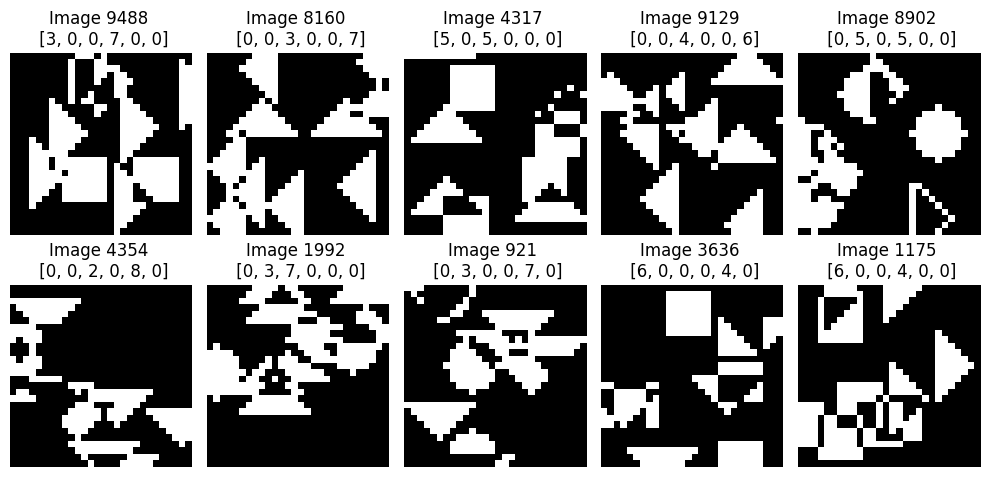

In [39]:
import matplotlib.pyplot as plt
import random

random_indices = random.sample(range(dataset.n_images), 10)

plt.figure(figsize=(10, 5))
for i, index in enumerate(random_indices):
    image_data = dataset.image_data[index].reshape((dataset.image_size.y, dataset.image_size.x))
    label = list([int(k) for k in dataset.y[index]])
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_data.numpy(), cmap='gray')
    plt.title(f"Image {index} \n {label}")
    plt.axis('off')

plt.tight_layout()
plt.savefig("dataset_example_nonaugmented.jpg")
plt.show()

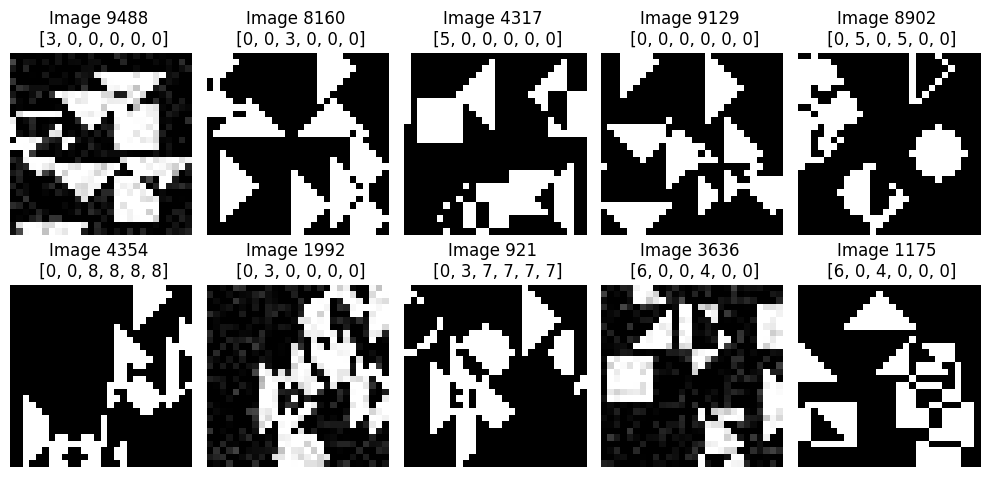

In [40]:
transform = AugmentationTransform(dataset,
                             {Augmentation.HORIZONTAL_FLIP, Augmentation.VERTICAL_FLIP, Augmentation.ROTATION, Augmentation.GAUSSIAN_NOISE},
                                 dataset.image_size)

plt.figure(figsize=(10, 5))
for i, index in enumerate(random_indices):
    sample_image, sample_label = dataset.image_data[index], dataset.y[index]
    sample_image_augmented, sample_label_augmented = transform(sample_image, sample_label)
    image_data = sample_image_augmented.reshape((dataset.image_size.y, dataset.image_size.x))
    label = list([int(k) for k in sample_label_augmented])
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_data.numpy(), cmap='gray')
    plt.title(f"Image {index} \n {label}")
    plt.axis('off')

plt.tight_layout()
plt.savefig("dataset_example_augmented.jpg")
plt.show()

Set up the model
===

In [21]:
class ShapeType(enum.Enum):
    """
    Figure shape classes.
    """
    SQUARE = 0
    CIRCLE = 1
    TRIANGLE_UP = 2
    TRIANGLE_RIGHT = 3
    TRIANGLE_DOWN = 4
    TRIANGLE_LEFT = 5

In [22]:
n_shape_classes = torch.combinations(torch.arange(len(ShapeType)), r=2)
n_figures = 10

output_classes = torch.cat((n_shape_classes.repeat_interleave(n_figures - 1, dim=0), torch.arange(1, n_figures).repeat(len(n_shape_classes)).view(-1, 1)), dim=1)
print(len(output_classes))
assert len(output_classes) == 135

135


In [23]:
class ShapeClassifier(nn.Module):
    @staticmethod
    def create_feature_extractor():
        feature_extractor = torch.nn.Sequential(
        nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(),
        nn.Flatten(start_dim=1),
        nn.Linear(64 * 28 * 28, 256), nn.ReLU())

        return feature_extractor

    def __init__(self, optimizer=torch.optim.Adam, lr=1e-3, epochs=100, batch_size=64, batch_size_val=1000):
        super().__init__()
        self.optimizer = optimizer
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.batch_size_val = batch_size_val

        self.loss_normalization_coef = 1

        self.feature_extractor = self.create_feature_extractor()
        self.head_shapes = torch.nn.Linear(256, len(output_classes))
        self.head_counts = torch.nn.Linear(256, len(ShapeType))

    def loss(self, logits_cls, target_shape, logits_counts, target_counts):
        return (torch.nn.functional.nll_loss(torch.log_softmax(logits_cls, dim=1), target_shape, reduction='mean') +
                self.loss_normalization_coef * torch.smooth_l1_loss(logits_counts, target_counts))

    def forward(self, x):
        features = self.feature_extractor(x)
        logits_cls = self.head_shapes(features)
        logits_counts = self.head_counts(features)
        return logits_cls, logits_counts


Load data
====

In [43]:
TRAIN_SHARE = 0.9

#indices = torch.randperm(len(dataset))
split_point = int(dataset.n_images * TRAIN_SHARE)
#train_indices = indices[:split_point]
#test_indices = indices[split_point:]

train_transform = AugmentationTransform(dataset,
                             {Augmentation.HORIZONTAL_FLIP, Augmentation.VERTICAL_FLIP, Augmentation.ROTATION, Augmentation.GAUSSIAN_NOISE},
                                 dataset.image_size)
train_subset = torch.utils.data.Subset(dataset, range(split_point))
train_subset.dataset.transform = train_transform

test_subset = torch.utils.data.Subset(dataset, range(split_point, dataset.n_images))

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=1000, shuffle=False)




Train the model
===

In [44]:
model = ShapeClassifier()

# TODO

ShapeClassifier(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=50176, out_features=256, bias=True)
    (10): ReLU()
  )
  (head_shapes): Linear(in_features=256, out_features=135, bias=True)
  (head_counts): Linear(in_features=256, out_features=6, bias=True)
)